In [204]:
import sys
sys.path.append('../')

In [205]:
from scripts.utils import data_path, set_mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import h5py


%matplotlib inline

set_mpl()

matplotlib settings set


In [206]:
data_std = pd.read_pickle(data_path+'London/london_std.pkl_gz', compression='gzip')
data_std = data_std.resample('1H').mean()


In [207]:
missed_frac = data_std.isna().mean(axis = 0).sort_values(ascending = False)
missed_frac.describe()

#drop columns with more than xx% missing values
data_std = data_std.drop(missed_frac[missed_frac > 0.3].index, axis = 1)
homes_col = data_std.columns


In [208]:

data_std['homes_num'] = data_std[homes_col].count(axis=1)

data_std['power_avg'] = data_std[homes_col].sum(axis=1)/data_std['homes_num']



for df in [data_std]:
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear
    df['day_of_week'] = df.index.day_name()

    df['season'] = df['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')
    df['workday'] = df['weekday'].apply(lambda x: 'workday' if x in [0, 1, 2, 3, 4] else 'weekend')


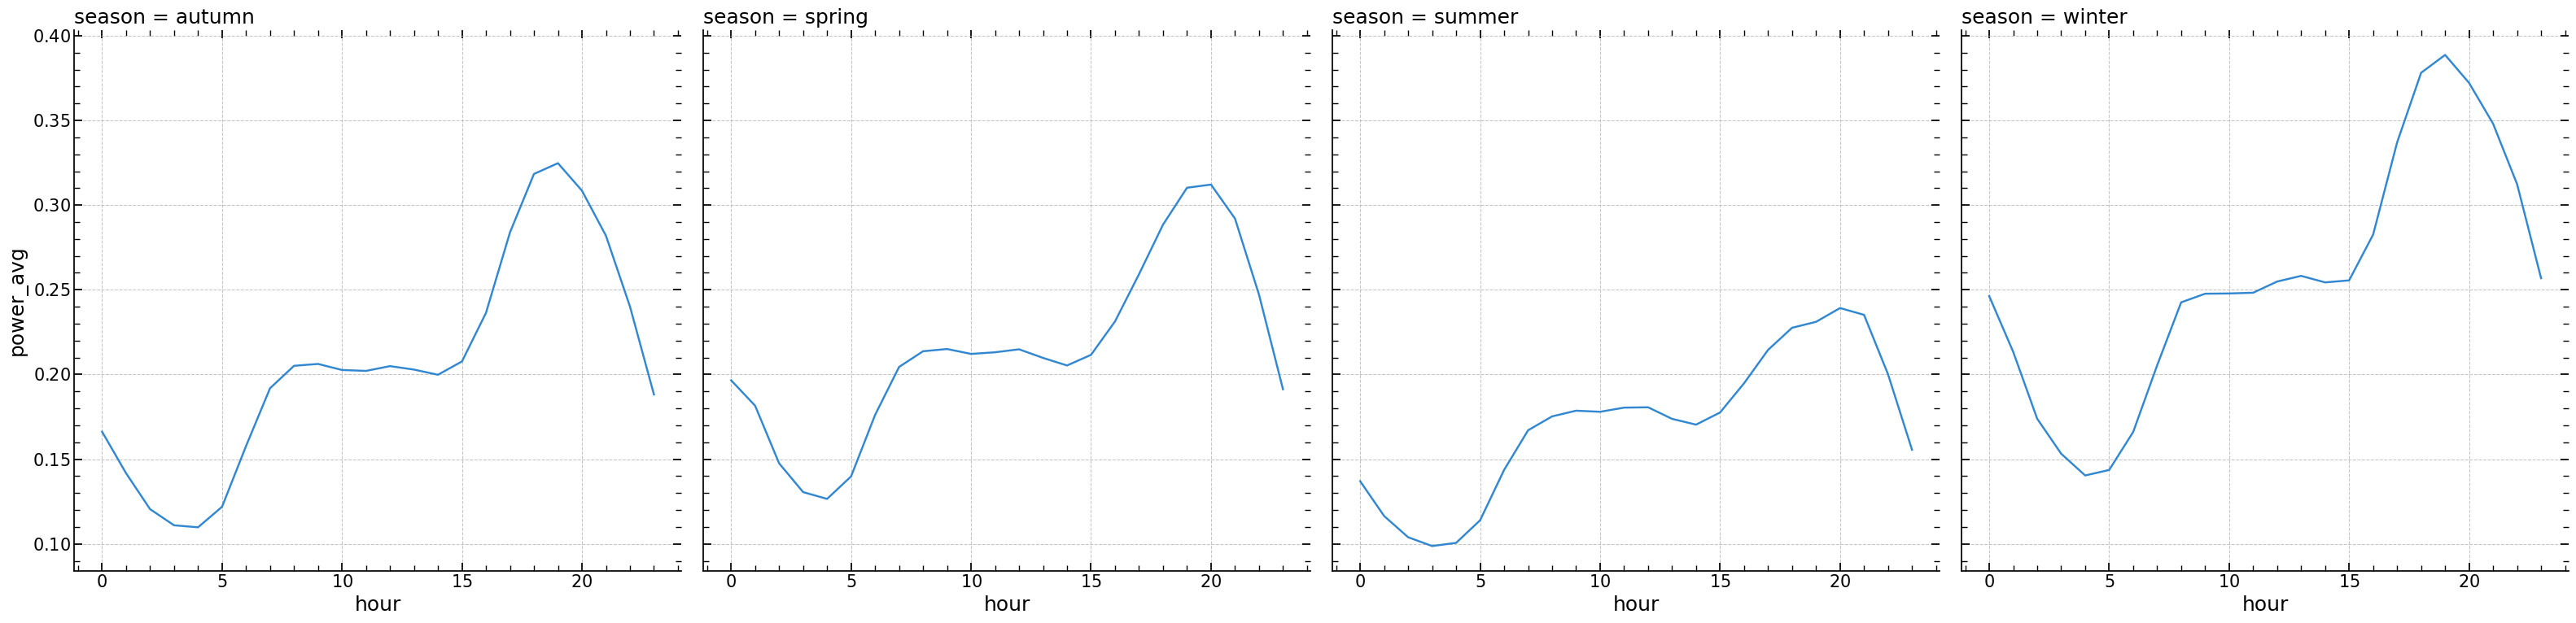

In [209]:
grp = data_std.groupby(['season', 'hour'])['power_avg'].mean()

sns.relplot(x='hour', y='power_avg', col='season', data=grp.reset_index(), kind='line', aspect=1, height=8)

# Clustering

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_88540/3725077778.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grp = data_std.groupby(grouping).mean()[homes_col].T


Text(0, 0.5, 'Inertia')

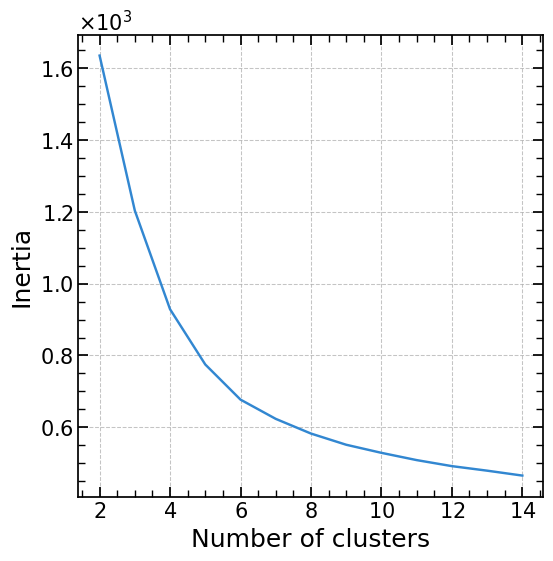

In [214]:
#make a kmeans clustering of homes according to their hourly average power consumption

from sklearn.cluster import KMeans
#grouping = ['season', 'hour']
grouping = ['hour']

grp = data_std.groupby(grouping).mean()[homes_col].T

inertia = []
clusters = []
for i in range(2,15):

    kmeans = KMeans(n_clusters=i, random_state=0).fit(grp)
    inertia.append(kmeans.inertia_)
    clusters.append(kmeans.labels_)

fig,  ax =  plt.subplots( figsize = (6,6))
ax.plot(range(2, 15), inertia)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')


0    1660
1    1191
2      84
3     468
4      53
Name: cluster, dtype: int64

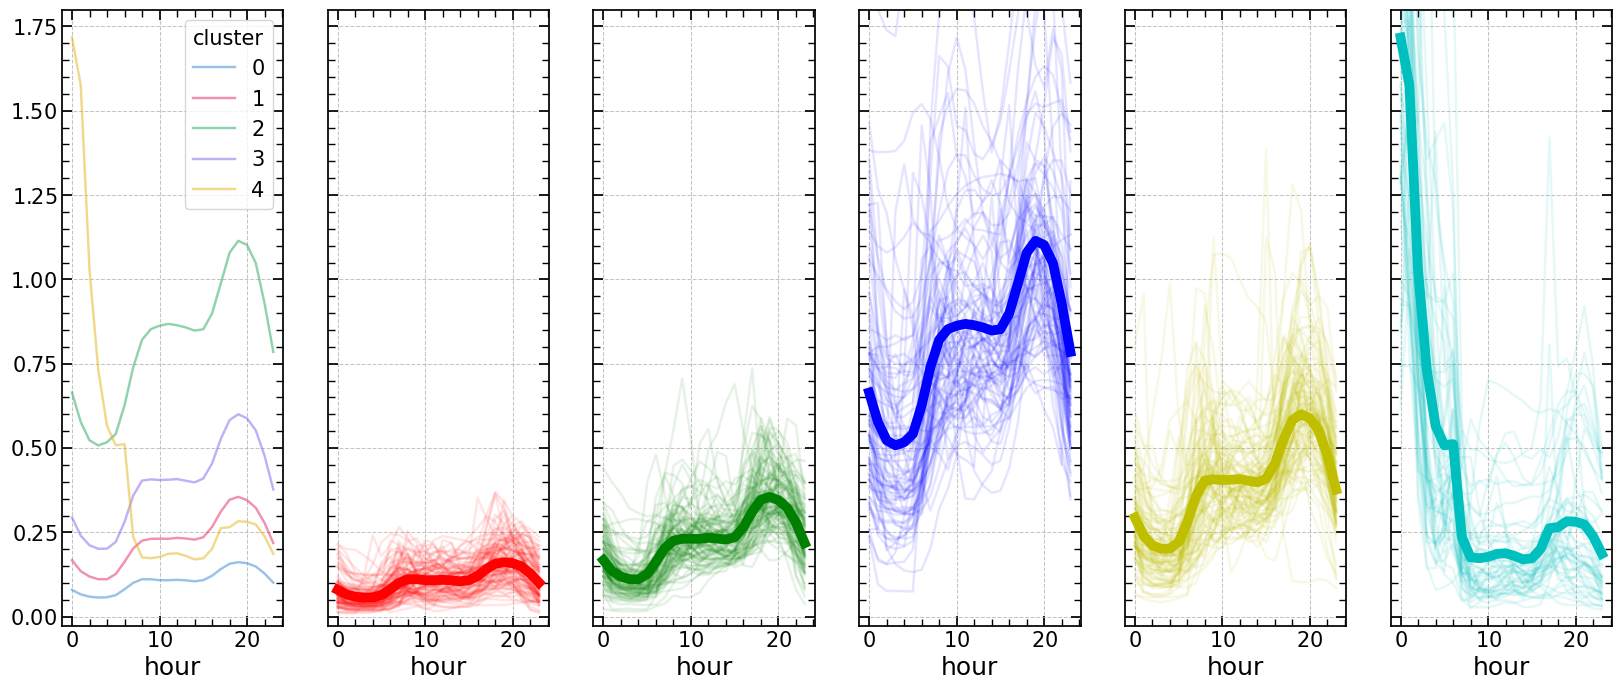

In [215]:
num_clu = 5

kmeans = KMeans(n_clusters=num_clu, random_state=0).fit(grp)

clusters_fin = kmeans.labels_


grp['cluster'] = clusters_fin
display(grp['cluster'].value_counts().sort_index())


fig,  axs =  plt.subplots(1, num_clu+1,  figsize = (20,8), sharey = True)
axs = axs.flatten()
grp.groupby('cluster').mean().T.plot(ax = axs[0], alpha = 0.5)
[ax.set_ylim() for ax in axs]

colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']



for i in range(num_clu):
    grp.query('cluster == @i').drop('cluster', axis = 1).mean().plot(ax = axs[i+1], color = colors[i], alpha = 1, lw = 7,  label = 'cluster {}'.format(i))

    grp_clu = grp[grp['cluster'] == i]
    if len(grp_clu) < 100:
        grp_clu = grp_clu
    else:
        grp_clu = grp_clu.sample(100)
    

    grp_clu = grp_clu.drop('cluster', axis = 1).T
    grp_clu.plot(ax = axs[i+1], color = colors[i], alpha = 0.1, legend = False)






In [216]:
# num_clu = 5

# kmeans = KMeans(n_clusters=num_clu, random_state=0).fit(grp)

# clusters_fin = kmeans.labels_

# id_to_cluster = dict(zip(grp.index, clusters_fin))
# cluster_to_id = {i:[] for i in range(num_clu)}
# for k, v in id_to_cluster.items():
#     cluster_to_id[v].append(k)


# clusters_dfs = []

# for i in range(num_clu):
#     mask = data_std[homes_col].columns.isin(cluster_to_id[i])
#     clusters_dfs.append(data_std[homes_col].loc[:, mask])



# #plot the average power consumption of each cluster

# fig,  ax =  plt.subplots( figsize = (6,6))
# for i in range(num_clu):
#     grp = clusters_dfs[i].groupby(grouping).mean()
